## Figures for Precambrian Research Submission - OFP
## **Crossplots**
  
Connor S. van Wieren, 2023

## Notes
- Want to be complete, so need a 2 subplot figure showing C-O crossplots against facies for both sections and clasts

In [2]:
import numpy as np
import random
random.seed(10)
import numpy.polynomial.polynomial as pl
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap as lm
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
from matplotlib import colors
import matplotlib
import pandas as pd
import seaborn as sns
from VanStrat.VanStrat_simple import *
import string
from scipy.ndimage import rotate
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import pickle
import dill
import sys
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Useful_Code')
from funcs import *
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.5, 3.5)
%config InlineBackend.figure_format='retina'

sns.set_style('ticks',{'axes.edgecolor':'.3',
                       'xtick.color':'.3',
                       'ytick.color':'.3',
                       'text.color': '.3',
                       'axes.labelcolor':'.3',
                       'axes.grid': False,
                       'grid.linestyle': u'-.'})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/OFP_PC/img/'

# load pickle
filename = './pickles/ofp_data.pkl'
dill.load_session(filename)

# read excels
secs = pd.read_excel(home+'./sections/sections_com.xlsx') # sections 
# get rid of secs duplicates
secs = secs.dropna(subset=['d13c_carb']).reset_index(drop=True) 

# Lump all Fold limbs for GSM Type into one section
secs.loc[secs['index'].str.contains('GSM Type'),'index'] = 'GSM Type'

clasts = pd.read_excel(home+'./ICTs/icts_com.xlsx') # ICT clasts
nods = pd.read_excel(home+'./hand_samples/nodules.xlsx') # GSM Authigenic Nodules
fans = pd.read_excel(home+'./hand_samples/fans.xlsx') # WMM aragonite fan clasts

# combine clasts and fans
clasts = pd.concat([clasts,fans]).reset_index(drop=True)

## Combine and Flag Data

In [2]:
nods['label']='Authigenic Nodules'
clasts['label'] = 'Clasts'
secs['label'] = 'Sections'

ofp = pd.concat([nods,clasts,secs])

# ICT

In [3]:
targ = 'index'
l = set(clasts[targ])
pal = sns.color_palette('Paired',n_colors=len(l)).as_hex()
pal

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00']

In [4]:
# ## Scatterplot
# fig,ax = plt.subplots(1,2,figsize=(10,4),sharex=True,sharey=True)#,layout='constrained')

# # Confidence ellipse version
# for idx,c in zip(l,pal):
#     t = clasts[clasts[targ]==idx]
#     lt = len(t)
#     sns.scatterplot(data=t,x='d18o_carb',y='d13c_carb',ax=ax[0],facecolor=c,edgecolor='none',legend=True,alpha=1,s=20,
#                     marker='o',label=f'{idx}; n = {lt}',clip_on=False,zorder=10) # clasts
#     loc = clasts[clasts[targ]==idx]
#     #confidence_ellipse(x=loc['d18o_carb'],y=loc['d13c_carb'],ax=ax[1],n_std=1,alpha=0.2,facecolor=c,lw=0.5,label='1$\sigma$')
#     confidence_ellipse(x=loc['d18o_carb'],y=loc['d13c_carb'],ax=ax[1],n_std=2,alpha=0.1,facecolor=c,lw=0.5,label='1$\sigma$')
#     meanx = np.mean(loc['d18o_carb'])
#     meany = np.mean(loc['d13c_carb'])
#     stdx = np.std(loc['d18o_carb'])
#     stdy = np.std(loc['d13c_carb'])
#     #markers, caps, bars = ax[1].errorbar(meanx,meany,xerr=stdx,yerr=stdy,marker='s',color='.4',zorder=3,markerfacecolor=c)
#     #[bar.set_alpha(0.5) for bar in bars]
#     markers, caps, bars = ax[1].errorbar(meanx,meany,xerr=2*stdx,yerr=2*stdy,marker='s',color='.4',zorder=2,markerfacecolor=c,markersize=8) # .8
#     [bar.set_alpha(0.3) for bar in bars]

# # format
# ax[1].set_xlim(ax[0].get_xlim())
# ax[1].set_ylim(ax[0].get_ylim())
# ax[0].grid()
# ax[1].grid()
# ax[0].set_xlabel('$\delta^{18}$O$_{carb}$ (‰)')
# ax[1].set_xlabel('$\delta^{18}$O$_{carb}$ (‰)')
# ax[0].set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
# ax[0].legend(loc=3,bbox_to_anchor=(2.2,0.3),ncol=2)
# ax[0].set_ylim(min(clasts['d13c_carb']),max(clasts['d13c_carb']))
# ax[0].set_xlim(min(clasts['d18o_carb']),max(clasts['d18o_carb']))

## Crossplot

## To Do: 
- [x] need to refine simplifications, sandstone is really carbonate cemented for example
- [x] need to refine zorder, some are hidden behind other data

In [5]:
locs = list(set(clasts['index']))
facs = list(set(clasts['sample_facies_simplified']))
print(f'number of localities = {len(locs)}\nnumber of facies = {len(facs)}')

number of localities = 8
number of facies = 7


In [6]:
marks=['s','d','o','^','v','<','>','h']
#marks = random.sample(marks,len(marks))
# x = np.arange(10)
# for idx,mark in enumerate(marks):
#     plt.plot(x[idx],2,marker=mark,lw=0)
# print(len(marks))

In [7]:
set(clasts['index'])

{'Boomerang',
 'GSM Type',
 'Jasper, Highway 16',
 'McKale Creek',
 'OFP Landmark',
 'Railway',
 'Redoubt',
 'Wolverine'}

In [8]:
style_orderc = ['McKale Creek','Jasper, Highway 16','GSM Type','OFP Landmark','Railway','Boomerang','Redoubt','Wolverine']

In [9]:
# fig,ax = plt.subplots(1,1,figsize=(7,5.5))

# # factorize facies for colour-mapping
# levels, categories = pd.factorize(clasts['sample_facies_simplified'])
# pal2 = sns.color_palette('tab20',n_colors=len(facs)).as_hex()
# pal = lm(pal2)

# # plot
# s = sns.scatterplot(x=clasts['d18o_carb'],y=clasts['d13c_carb'],ax=ax,edgecolor='none',
#                     hue=levels,palette=pal,style=clasts['index'],style_order=style_orderc,markers=marks,clip_on=False,zorder=10,alpha=1)

# # deal with colourbar
# tick_locs = (np.arange(len(facs))+0.5)*(len(facs)-1)/len(facs) # set to center
# norm = plt.Normalize(levels.min(), levels.max())
# sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm,ax=ax,ticks=tick_locs,pad=0.02,orientation='vertical',location='right')
# cbar.ax.set_yticklabels(categories,fontsize=12);

# # add section distribution
# sns.scatterplot(x=secs['d18o_carb'],ax=ax,y=secs['d13c_carb'],edgecolor='none',color='darkgrey',clip_on=False,zorder=2,alpha=1,s=40,legend=False)
# points = secs[['d18o_carb','d13c_carb']].to_numpy()
# hull = ConvexHull(points)
# #for simplex in hull.simplices:
#     #ax.plot(points[simplex, 0], points[simplex, 1], 'grey',zorder=1)
# ax.fill(points[hull.vertices,0], points[hull.vertices,1], 'k', alpha=0.1,label='all sections',zorder=1)
# #confidence_ellipse(x=secs['d18o_carb'],y=secs['d13c_carb'],ax=ax,n_std=2,alpha=0.2,facecolor='grey',lw=0,label='2$\sigma$')

# # shape by location formatting and legend
# num_of_colors   = len(facs) + 1
# handles, labels = s.get_legend_handles_labels()
# fac_hl = handles[6:-1], labels[6:-1]
# comp_hl = handles[-1:], labels[-1:]

# # Call legend twice #
# comp_leg = s.legend(*comp_hl,loc='upper left',framealpha=1,fontsize=10,
#                    frameon=True,labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)
# fac_leg = s.legend(*fac_hl,loc='lower left',bbox_to_anchor=(0,1),framealpha=1,ncol=len(locs)/2,fontsize=9,frameon=False,
#                labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)
# ax.add_artist(comp_leg)
# for leg in [comp_leg,fac_leg]:
#     frame = leg.get_frame()
#     frame.set_edgecolor('.3')
#     frame.set_linewidth(.75)
#     frame.set_boxstyle('square')

# # format
# ax.set_xlabel('$\delta^{18}$O$_{carb}$ (‰)',fontsize=12)
# ax.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)',fontsize=12);
# ax.grid()
# ax.set_ylim(min(clasts['d13c_carb']),max(clasts['d13c_carb']))
# ax.set_xlim(min(clasts['d18o_carb']),max(clasts['d18o_carb']))



In [10]:
len(set(clasts['sample_facies_simplified']))

7

# Sections

## Crossplot

In [11]:
locs = list(set(secs['index']))
facs = list(set(secs['sample_facies_simplified']))
print(f'number of localities = {len(locs)}\nnumber of facies = {len(facs)}')

number of localities = 7
number of facies = 7


In [12]:
marks=['s','d','o','^','v','<','>']
#marks = random.sample(marks,len(marks))
#x = np.arange(10)
# for idx,mark in enumerate(marks):
#     plt.plot(x[idx],2,marker=mark,lw=0)
# print(len(marks))

In [13]:
set(secs['index'])

{'GSM Type',
 'Marmot Road',
 'McKale Creek',
 'Pyrite Point',
 'Railway',
 'Temple Lake',
 'Wolverine'}

In [14]:
style_orders = ['McKale Creek','Marmot Road','GSM Type','Railway','Pyrite Point','Temple Lake','Wolverine']

In [15]:
# fig,ax = plt.subplots(1,1,figsize=(7,5.5))

# # factorize facies for colour-mapping
# levels, categories = pd.factorize(secs['sample_facies_simplified'])
# pal2 = sns.color_palette('tab20',n_colors=len(facs)).as_hex()
# pal = lm(pal2)

# # plot
# s = sns.scatterplot(x=secs['d18o_carb'],y=secs['d13c_carb'],ax=ax,edgecolor='none',
#                     hue=levels,palette=pal,style=secs['index'],markers=marks,style_order=style_orders,clip_on=False,zorder=10,alpha=1)

# # deal with colourbar
# tick_locs = (np.arange(len(facs))+0.5)*(len(facs)-1)/len(facs) # set to center
# norm = plt.Normalize(levels.min(), levels.max())
# sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm,ax=ax,ticks=tick_locs,pad=0.02,orientation='vertical',location='right')
# cbar.ax.set_yticklabels(categories,fontsize=12);

# # shape by location formatting and legend
# num_of_colors   = len(facs) + 1
# handles, labels = s.get_legend_handles_labels()
# hl = handles[6:], labels[6:]

# # Call legend twice #
# leg = s.legend(*hl,loc='lower left',bbox_to_anchor=(-0.04,1),framealpha=1,ncol=4,fontsize=9,frameon=False,
#                labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)

# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')

# # format
# ax.set_xlabel('$\delta^{18}$O$_{carb}$ (‰)',fontsize=12)
# ax.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)',fontsize=12);
# ax.grid()
# ax.set_ylim(min(secs['d13c_carb']),max(secs['d13c_carb']))
# ax.set_xlim(min(secs['d18o_carb']),max(secs['d18o_carb']))


# Combine into subplot figure

In [16]:
marks_c = ['s','d','o','^','v','<','>','h']
marks_s = ['s','d','o','^','v','<','>']
marks_t = ['s','d','o','^','h','<','>','v','X','P','*']

style_orders = ['McKale Creek','Marmot Road','GSM Type','Pyrite Point','Railway','Temple Lake','Wolverine']
style_orderc = ['McKale Creek','Jasper, Highway 16','GSM Type','OFP Landmark','Railway','Boomerang','Wolverine','Redoubt']
style_ordert = list(np.unique(style_orders + style_orderc))

locs_c = list(set(clasts['index']))
facs_c = list(set(clasts['sample_facies_simplified']))
locs_s = list(set(secs['index']))
facs_s = list(set(secs['sample_facies_simplified']))
facs_n = list(set(nods['sample_facies_simplified']))

cs = pd.concat([clasts,secs,nods])
fs = set(facs_c+facs_s+facs_n)

In [17]:
style_ordert

['Boomerang',
 'GSM Type',
 'Jasper, Highway 16',
 'Marmot Road',
 'McKale Creek',
 'OFP Landmark',
 'Pyrite Point',
 'Railway',
 'Redoubt',
 'Temple Lake',
 'Wolverine']

In [18]:
set(cs['sample_facies_simplified'])

{'aragonite fan',
 'authigenic carbonate nodule',
 'crystalline limestone',
 'dolostone',
 'grainstone',
 'ls mudstone',
 'sandy dolostone',
 'sandy limestone',
 'wackestone'}

In [19]:
# make this sorted version colours line up with old version (easier on the eye)
pal = sns.color_palette('tab20',n_colors=12).as_hex() # tab20
pal

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94']

In [20]:
list(pal)

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5',
 '#8c564b',
 '#c49c94']

In [21]:
csrt = ['#1f77b4','#c49c94','#ffbb78','#ff7f0e','#2ca02c','#98df8a','#aec7e8','#9467bd','#d62728']

In [22]:
pal2 = sns.color_palette(csrt).as_hex()
pal2

['#1f77b4',
 '#c49c94',
 '#ffbb78',
 '#ff7f0e',
 '#2ca02c',
 '#98df8a',
 '#aec7e8',
 '#9467bd',
 '#d62728']

In [23]:
# jon wants sorted in increasing gs by ls, sl, sandy, authigenic
sorting = ['ls mudstone','wackestone','grainstone','crystalline limestone','dolostone','sandy dolostone','sandy limestone','authigenic carbonate nodule','aragonite fan']
cs.sort_values(by='sample_facies_simplified', key=lambda column: column.map(lambda x: sorting.index(x)), inplace=True)

In [24]:
# to make plotting on one colourbar easier, make them all have all the data, but make nan on either clasts or sections as needed
# included nodules with section data for reference
cs_noclast = cs.copy()
cs_nosec = cs.copy()
cs_noclast.loc[cs_noclast['label']=='Clasts',['d13c_carb','d18o_carb']] = np.nan
cs_nosec.loc[cs_nosec['label']=='Sections',['d13c_carb','d18o_carb']] = np.nan
cs_nosec.loc[cs_nosec['label'].str.contains('Sec|Auth'),['d13c_carb','d18o_carb']] = np.nan

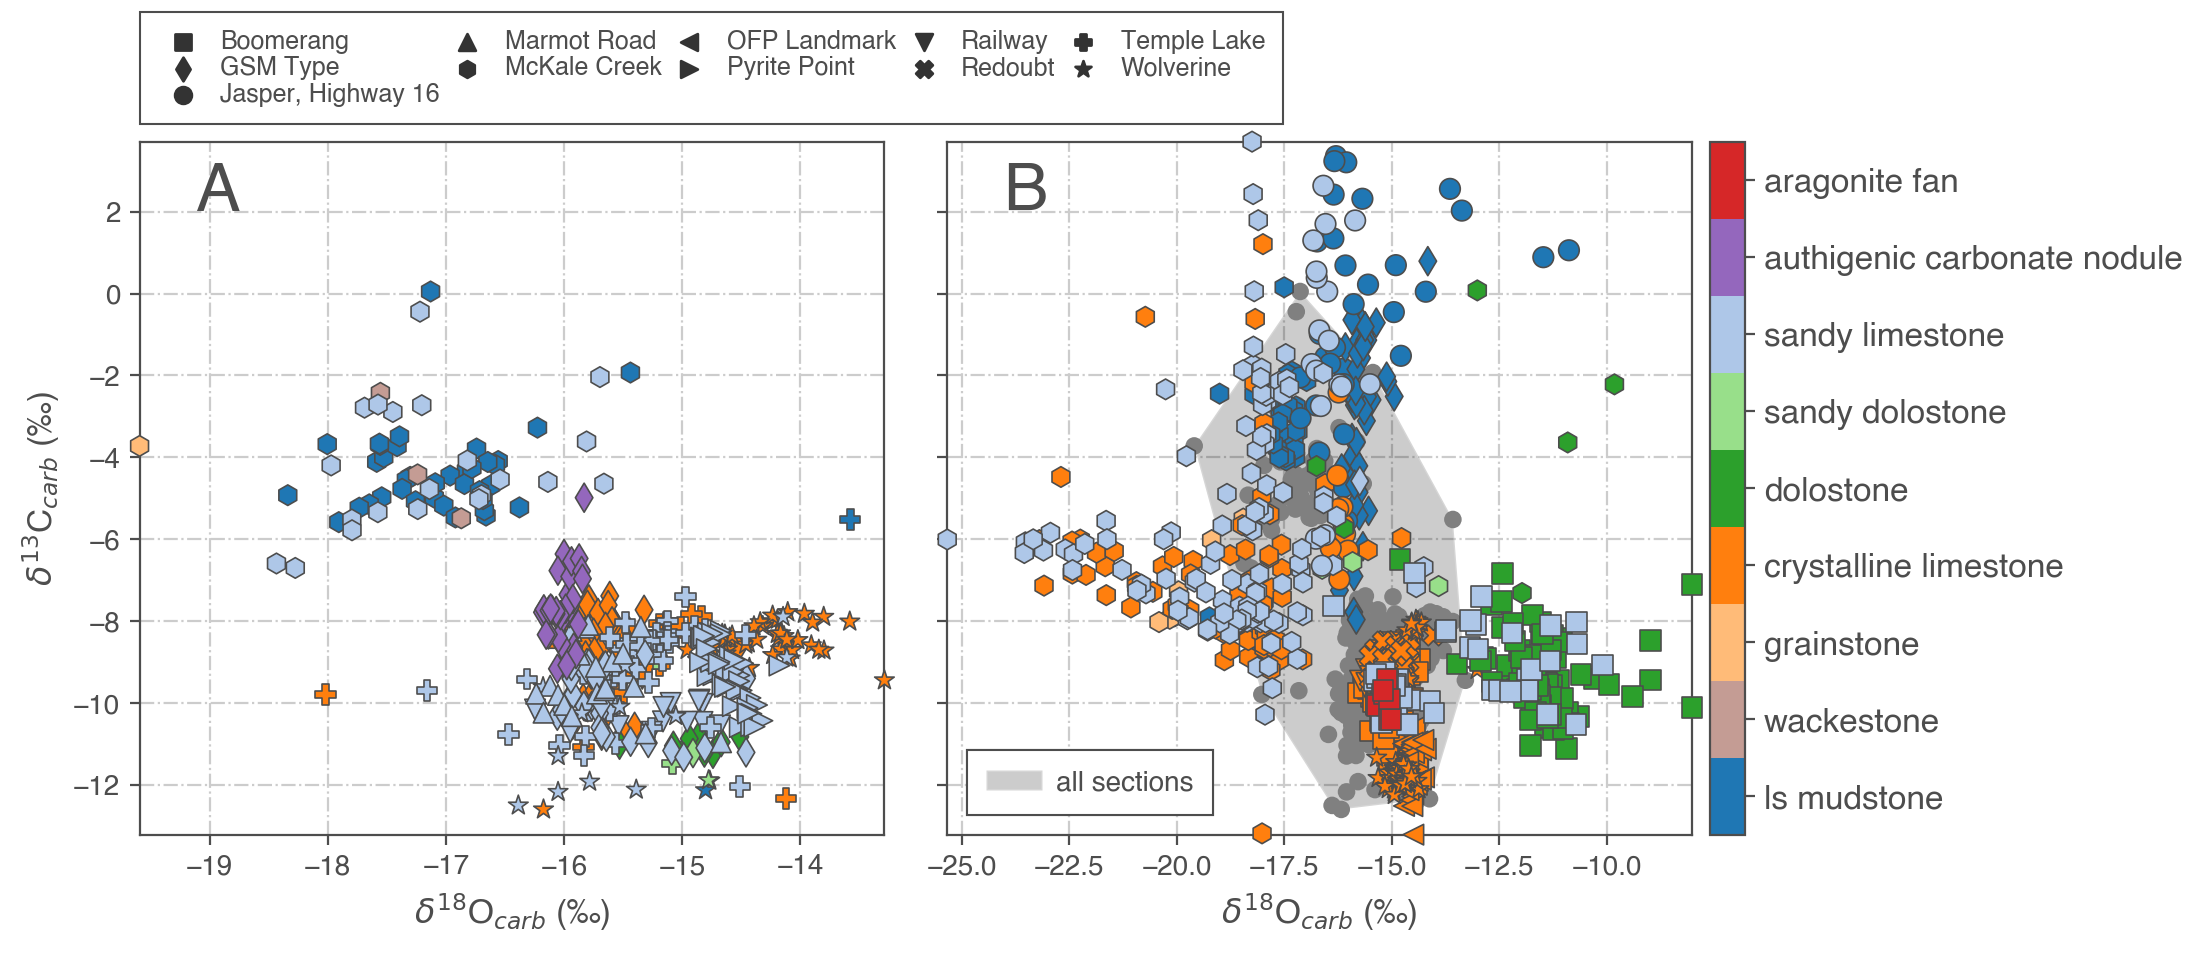

In [25]:
fig,ax = plt.subplots(1,2,figsize=(11,4.5),width_ratios=[1,1],sharey=True,sharex=False)
plt.subplots_adjust(wspace=-0.1)

# factorize facies for colour-mapping
l,c = pd.factorize(cs['sample_facies_simplified'])
#pal2 = sns.color_palette('tab20',n_colors=len(fs)).as_hex() # tab20
pal = lm(pal2)

# clasts
sc = sns.scatterplot(x=cs_nosec['d18o_carb'],y=cs_nosec['d13c_carb'],ax=ax[1],edgecolor='.3',
                    hue=l,palette=pal,style=cs_nosec['index'],markers=marks_t,style_order=style_ordert,clip_on=False,zorder=10,alpha=1,legend=True,s=55)
# sections
ss = sns.scatterplot(x=cs_noclast['d18o_carb'],y=cs_noclast['d13c_carb'],ax=ax[0],edgecolor='.3',
                    hue=l,palette=pal,style=cs_noclast['index'],markers=marks_t,style_order=style_ordert,clip_on=False,zorder=10,alpha=1,legend=True,s=55)


# deal with colourbar
tick_locs = (np.arange(len(fs))+0.5)*(len(fs)-1)/len(fs) # set to center
norm = plt.Normalize(l.min(), l.max())
sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
cbar = plt.colorbar(sm,ax=ax[1],ticks=tick_locs,pad=0.02,orientation='vertical',location='right')
cbar.ax.set_yticklabels(c,fontsize=12);
cb = plt.colorbar(sm,ax=ax[0],ticks=tick_locs,pad=0.02,orientation='vertical',location='right',shrink=1e-8)
cb.ax.axis('off')

# add section distribution
sns.scatterplot(x=secs['d18o_carb'],ax=ax[1],y=secs['d13c_carb'],edgecolor='none',color='grey',clip_on=False,zorder=2,alpha=1,s=40,legend=False)
points = secs[['d18o_carb','d13c_carb']].to_numpy()
hull = ConvexHull(points)
ax[1].fill(points[hull.vertices,0], points[hull.vertices,1], 'k', alpha=0.2,label='all sections',zorder=1)

# shape by location formatting and legend
num_of_colors   = len(facs_s) + 1
handles, labels = ss.get_legend_handles_labels()
hl = handles[6:], labels[6:]

#for i in range(2):
    #ax[i].axhspan(max(secs['d13c_carb'])+0.2,14,alpha=0.1,color='tab:red',zorder=0)
    #ax[i].axhline(max(secs['d13c_carb'])+0.2,alpha=.5,color='k',zorder=0,ls='--')


# Call legend twice #
leg = ss.legend(*hl,loc='lower left',bbox_to_anchor=(-0.0225,1),framealpha=1,ncol=5,fontsize=9,frameon=True,
               labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)

frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# clasts
# shape by location formatting and legend
num_of_colors   = len(facs_c) + 1
handles, labels = sc.get_legend_handles_labels()
loc_hl = handles[6:-1], labels[6:-1]
hul_hl = handles[-1:], labels[-1:]

# Call legend twice #
hul_leg = sc.legend(*hul_hl,loc='lower left',framealpha=1,fontsize=10,
                   frameon=True,labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)
#loc_leg = sc.legend(*loc_hl,loc='lower left',bbox_to_anchor=(0,1),framealpha=1,ncol=4,fontsize=9,frameon=False,
               #labelspacing=0.1,columnspacing=0.1,handletextpad=0.5,borderaxespad=1)
ax[1].add_artist(hul_leg)
for leg in [hul_leg]:
    frame = leg.get_frame()
    frame.set_edgecolor('.3')
    frame.set_linewidth(.75)
    frame.set_boxstyle('square')

# format
for i,j in enumerate([secs,clasts]):
    ax[i].set_xlabel('$\delta^{18}$O$_{carb}$ (‰)',fontsize=12)
    ax[i].set_ylabel('$\delta^{13}$C$_{carb}$ (‰)',fontsize=12);
    ax[i].grid()
    ax[i].set_ylim(min(j['d13c_carb']),max(j['d13c_carb']))
    ax[i].set_xlim(min(j['d18o_carb']),max(j['d18o_carb']))

# label
labs = ['A','B']
for i ,j in enumerate(labs):
    ax[i].text(0.075,0.9,j,transform=ax[i].transAxes,fontsize=24)

fig.savefig(fig_dir+'cross.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [26]:
# g = sns.FacetGrid(cs, col = 'label', hue = 'sample_facies_simplified', palette = 'tab20')
# g = g.map(sns.scatterplot, 'd18o_carb', 'd13c_carb',s=10,)
# g.add_legend()

## boxplots

In [27]:
cl_nf = clasts[~clasts['sample_facies_simplified'].str.contains('fan')]
cl_f = clasts[clasts['sample_facies_simplified'].str.contains('fan')]
data = {'nodules': nods, 'clasts': cl_nf,'TLM Sections':secs[secs['index']!='McKale Creek'],'WMM Sections':secs[secs['index']=='McKale Creek'],
        'aragonite\nfans':cl_f}
df = pd.concat(data, names=['dtype']).reset_index(level=0)

In [28]:
# sort by decreasing median
sub = df.groupby(['dtype'])['d13c_carb'].mean().sort_values().iloc[::-1]
order = sub.index

In [29]:
df.groupby(['dtype'])['d13c_carb'].describe()

,count,mean,std,min,25%,50%,75%,max
dtype,,,,,,,,
TLM Sections,298.0,-9.287281,1.129947,-12.594845,-10.072376,-9.079976,-8.401005,-5.516160
WMM Sections,62.0,-4.290419,1.236212,-6.699127,-5.058652,-4.542137,-3.722427,0.049881
aragonite\nfans,7.0,-9.949420,0.363470,-10.399679,-10.228180,-9.897110,-9.738441,-9.415905
clasts,961.0,-8.049881,3.274234,-13.210600,-9.960342,-9.010567,-6.858624,3.708195
nodules,32.0,-7.615132,0.892420,-9.161009,-8.136211,-7.730314,-6.949974,-4.984458


In [30]:
df.groupby(['dtype'])['d18o_carb'].describe()

,count,mean,std,min,25%,50%,75%,max
dtype,,,,,,,,
TLM Sections,298.0,-15.177355,0.657477,-18.021008,-15.683944,-15.277571,-14.668375,-13.286414
WMM Sections,62.0,-17.141751,0.711660,-19.594284,-17.561698,-17.172120,-16.703053,-15.437454
aragonite\nfans,7.0,-15.136655,0.112905,-15.344475,-15.187737,-15.105416,-15.055483,-15.020252
clasts,961.0,-15.561739,2.380723,-25.339485,-16.763199,-15.064457,-14.663288,-8.012815
nodules,32.0,-16.001225,0.098980,-16.182518,-16.066220,-15.992664,-15.933577,-15.829502


/var/folders/ss/pfgdfm2x7_s4cyw2v0b_t7q80000gn/T/ipykernel_10980/1648511041.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=df,x='dtype',y='d13c_carb',order=order,ax=ax,size=7,edgecolor='none',linewidth=1,palette='GnBu',jitter=True,alpha=0.8,zorder=0)


Text(0, 0.5, '$\\delta^{13}$C$_{carb}$ (‰)')

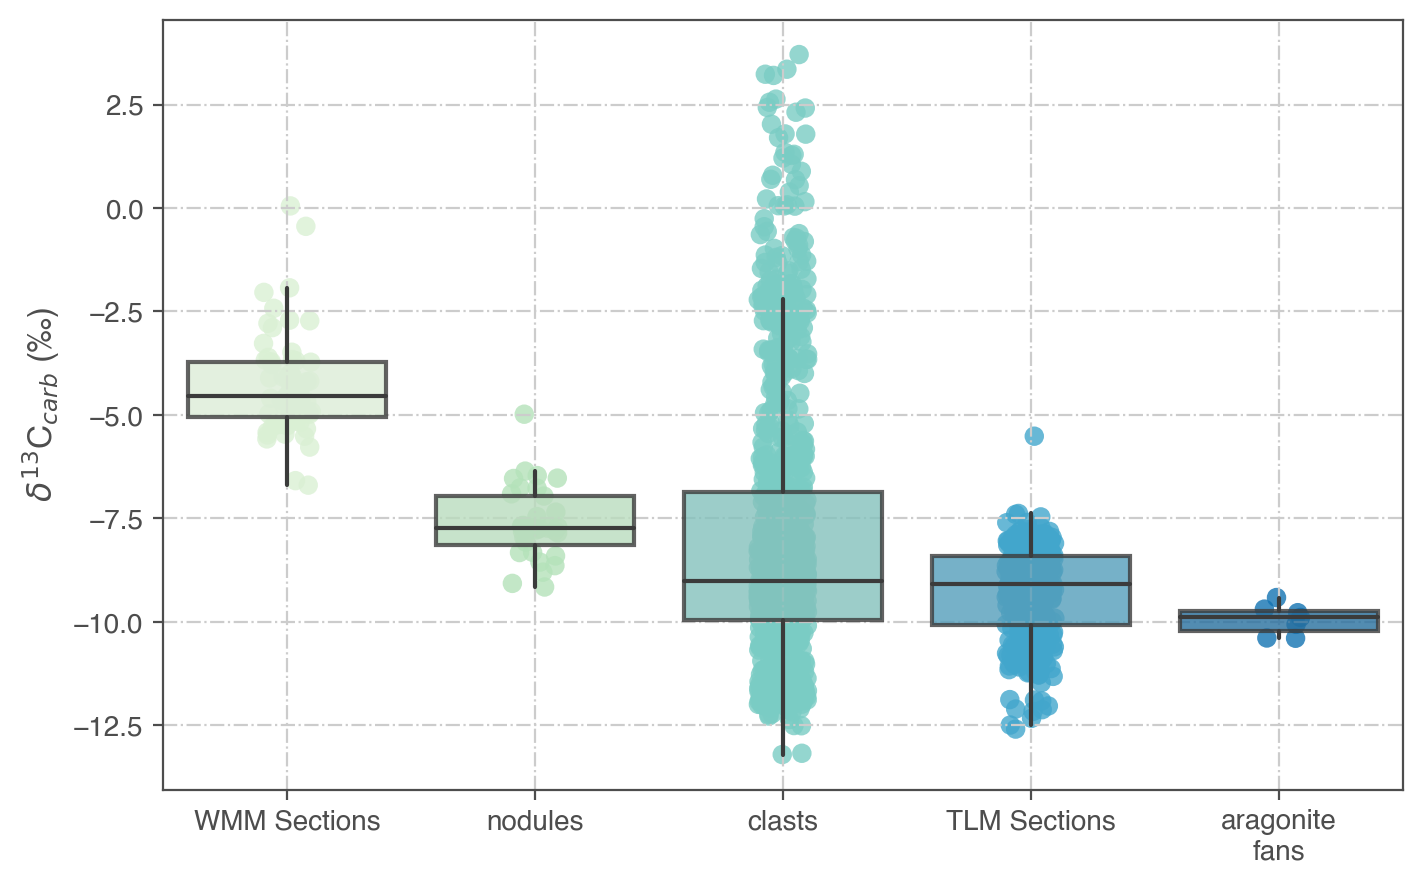

In [31]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
b = sns.boxplot(data=df,x='dtype',y='d13c_carb',order=order,ax=ax,palette='GnBu',showfliers=False,flierprops=dict(marker='o'),
            capprops=dict(linewidth=0),boxprops=dict(alpha=0.8),
            showmeans=False,meanprops=dict(marker='s',markerfacecolor='.3',alpha=0.8,mec='.3',markersize=6))
sns.stripplot(data=df,x='dtype',y='d13c_carb',order=order,ax=ax,size=7,edgecolor='none',linewidth=1,palette='GnBu',jitter=True,alpha=0.8,zorder=0)
ax.grid()

m =round(sub,2)
n = [len(df[df['dtype']==i]) for i in sub.index]
max_c = [max(df['d13c_carb'][df['dtype']==i]) for i in sub.index]

ax.set_xlabel(None)
ax.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)',fontsize=12)

#for xtick,n,t in zip(b.get_xticks(),n,max_c):
    #b.text(xtick,2*t,n, horizontalalignment='center',size='large',color='k',weight='semibold',zorder=100) 
    # bbox=dict(facecolor='w',edgecolor='.3',boxstyle='square,pad=0.5')

#fig.savefig(fig_dir+'box_comp.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Authigenic Carbonates d13C distriubutions

In [32]:
#fans1 = fans[~fans['sample_facies_simplified'].str.contains('ls mudstone|sandstone|muds')].reset_index(drop=True)
fans1 = fans[~fans['facies'].str.contains('clast|matrix|muds')].reset_index(drop=True)

In [33]:
fans1

,sample_name,Beam Area,d13c_carb,d18o_carb,facies,sample_facies_simplified,sample_height,index,member
0,C16_17D_AF5,3.192012e-07,-9.695452,-15.201329,thin fan,aragonite fan,17,Boomerang,WMM
1,C16_17D_AF7,3.133549e-07,-9.897110,-15.054083,thick fan top,aragonite fan,17,Boomerang,WMM
2,C16_17D_AF8,4.373257e-07,-10.393137,-15.020252,thick fan middle,aragonite fan,17,Boomerang,WMM
3,C16_17D_AF9,2.897446e-07,-9.415905,-15.105416,thick fan top,aragonite fan,17,Boomerang,WMM
4,C16_17D_AF10,4.679577e-07,-10.399679,-15.056883,thick fan bottom,aragonite fan,17,Boomerang,WMM


In [34]:
nods1 = nods[nods['sample_height']==169].reset_index(drop=True)
nods2 = nods[nods['sample_height']==170].reset_index(drop=True)

In [35]:
tlms = secs[secs['member']=='TLM']
wmms = secs[secs['member']=='WMM']

(-16.25, -14.95)

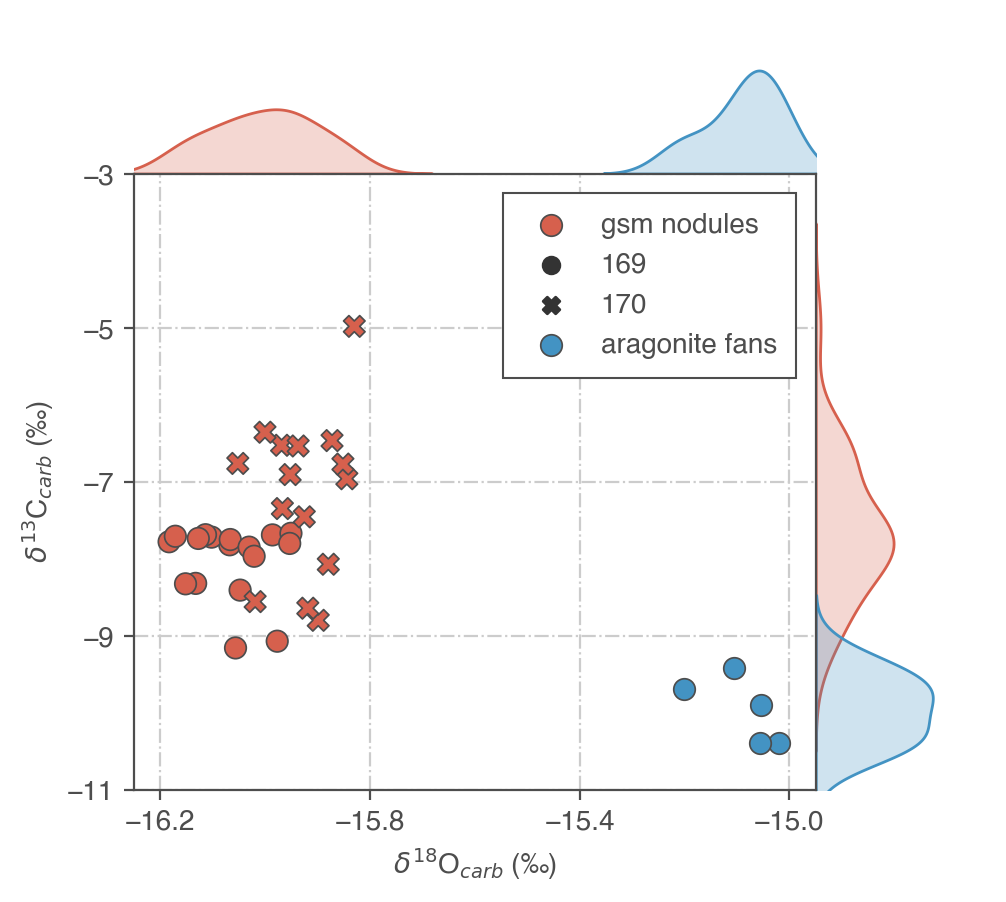

In [36]:
fig,ax = plt.subplot_mosaic(
    """
    AA.
    BBC
    BBC
    
    """,figsize=(5.5,5),width_ratios=[1,1,.5],height_ratios=[.5,1,1])

pal = sns.color_palette('RdBu',n_colors=4).as_hex()
plt.subplots_adjust(wspace=0,hspace=0)
sns.kdeplot(data=nods,y='d13c_carb',ax=ax['C'],fill=True,label='gsm nodules',common_norm=True,color=pal[0])
sns.kdeplot(data=fans1,y='d13c_carb',ax=ax['C'],fill=True,label='aragonite fans',common_norm=True,color=pal[-1])
sns.kdeplot(data=nods,x='d18o_carb',ax=ax['A'],fill=True,label='gsm nodules',common_norm=True,color=pal[0])
sns.kdeplot(data=fans1,x='d18o_carb',ax=ax['A'],fill=True,label='aragonite fans',common_norm=True,color=pal[-1])
ax['A'].sharex(ax['B'])
ax['C'].sharey(ax['B'])
for i in ['A','C']:
    ax[i].axis('off')
ax['A'].set_ylim(top=8)
ax['C'].set_xlim(right=1)

ax['B'].set_zorder(100)
ax['B'].set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
ax['B'].set_xlabel('$\delta^{18}$O$_{carb}$ (‰)')
ax['B'].grid()

# scatter
sns.scatterplot(data=nods,x='d18o_carb',y='d13c_carb',style='sample_height',ax=ax['B'],edgecolor='.3',facecolor=pal[0],s=60,label='gsm nodules')
sns.scatterplot(data=fans1,x='d18o_carb',y='d13c_carb',ax=ax['B'],edgecolor='.3',facecolor=pal[-1],s=60,label='aragonite fans')
leg = ax['B'].legend(framealpha=1,fontsize=10,borderaxespad=1)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

ax['B'].set_xticks(np.arange(-16.2,-14.4,.4))
ax['B'].set_yticks(np.arange(-11,-2,2))
ax['B'].set_ylim(-11,-3)
ax['B'].set_xlim(-16.25,-14.95)

In [37]:
pal = sns.color_palette('RdBu',n_colors=6).as_hex()
pal

['#c13639', '#f09c7b', '#fbe3d4', '#dbeaf2', '#87beda', '#2f79b5']

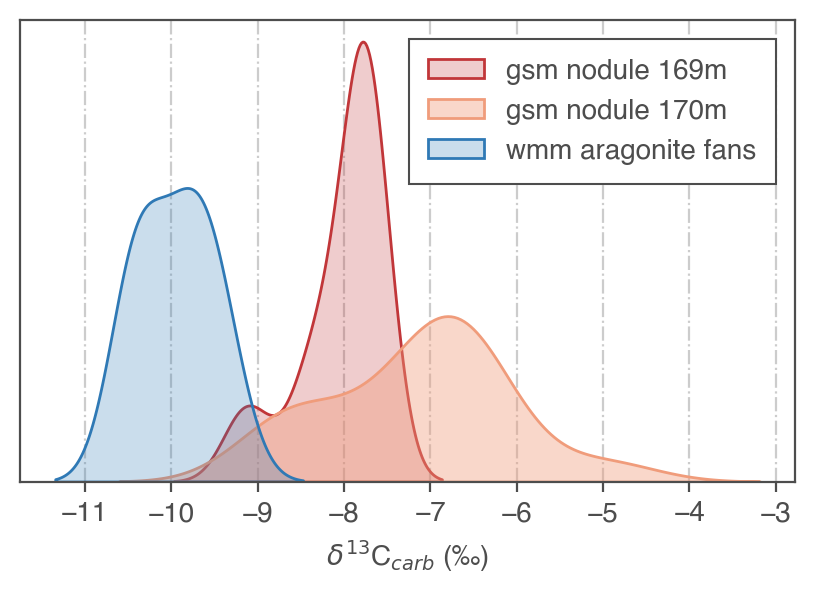

In [38]:
fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.grid(zorder=0)
ax.set_yticks([])
sns.kdeplot(data=nods1,x='d13c_carb',fill=True,label='gsm nodule 169m',color=pal[0])
sns.kdeplot(data=nods2,x='d13c_carb',fill=True,label='gsm nodule 170m',color=pal[1],alpha=0.4)
sns.kdeplot(data=fans1,x='d13c_carb',fill=True,label='wmm aragonite fans',color=pal[-1])
leg = ax.legend(framealpha=1,fontsize=10,borderaxespad=1)
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')
ax.set_xlabel('$\delta^{13}$C$_{carb}$ (‰)')

fig.savefig(fig_dir+'auth1.pdf',format='pdf',bbox_inches='tight',transparent=True)

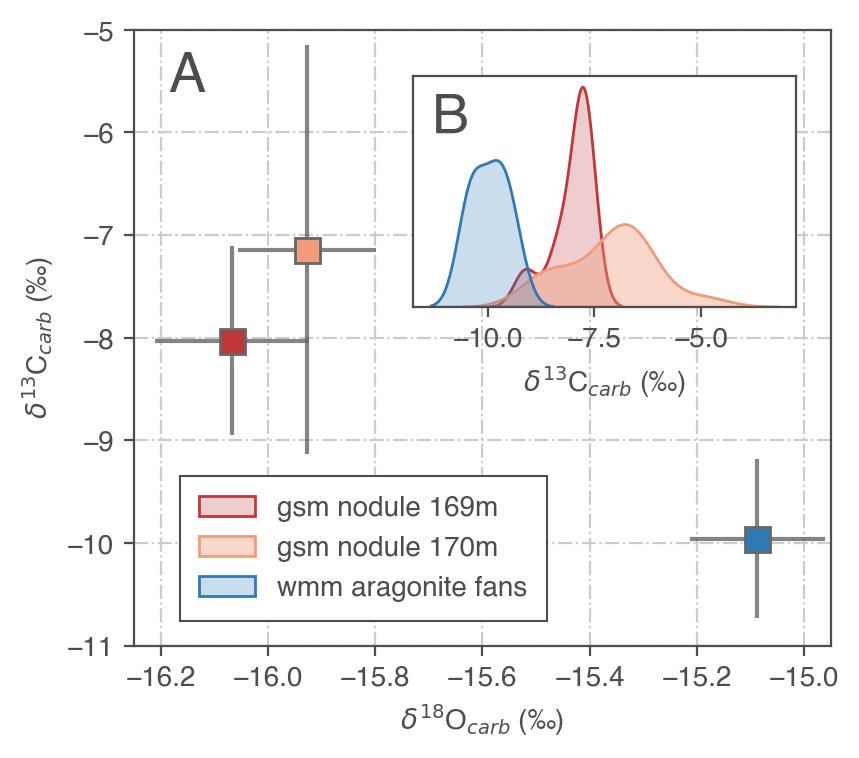

In [39]:
#sns.set_context('paper')

fig,ax = plt.subplots(figsize=(4.5,4))
ax.grid()
ax.set_ylabel('$\delta^{13}$C$_{carb}$ (‰)')
ax.set_xlabel('$\delta^{18}$O$_{carb}$ (‰)')

#pal = sns.color_palette('RdBu',n_colors=4).as_hex()
for i,c,l in zip([nods1,nods2,fans1],[pal[0],pal[1],pal[-1]],['gsm nodule 169m','gsm nodule 170m','wmm aragonite fans']):
    mc = np.mean(i['d13c_carb'])
    mo = np.mean(i['d18o_carb'])
    sc = np.std(i['d13c_carb'])
    so = np.std(i['d18o_carb'])

    # errorbars
    markers,caps,bars = ax.errorbar(mo,mc,xerr=2*so,yerr=2*sc,marker='s',color='.4',zorder=2,markerfacecolor=c,markersize=9,label=l)
    [b.set_alpha(.8) for b in bars]

axi = ax.inset_axes([0.4,0.55,0.55,0.375])
#axi.grid(zorder=0)
axi.set_yticks([])
sns.kdeplot(data=nods1,x='d13c_carb',ax=axi,fill=True,label='gsm nodule 169m',color=pal[0])
sns.kdeplot(data=nods2,x='d13c_carb',ax=axi,fill=True,label='gsm nodule 170m',color=pal[1],alpha=0.4)
sns.kdeplot(data=fans1,x='d13c_carb',ax=axi,fill=True,label='wmm aragonite fans',color=pal[-1])
axi.set_xlabel('$\delta^{13}$C$_{carb}$ (‰)')
#axi.spines[['left','right','top']].set_visible(False)
#axi.patch.set_facecolor('none')

leg = axi.legend(framealpha=1,fontsize=10,borderaxespad=1,bbox_to_anchor=(0.4,-0.65))
frame = leg.get_frame()
frame.set_edgecolor('.3')
frame.set_linewidth(.75)
frame.set_boxstyle('square')

# leg = ax.legend(framealpha=1,fontsize=10,borderaxespad=1)
# frame = leg.get_frame()
# frame.set_edgecolor('.3')
# frame.set_linewidth(.75)
# frame.set_boxstyle('square')

# format
ax.set_ylim(-11,-5)
ax.set_xlim(-16.25,-14.95)

# label
ax.text(0.05,0.9,'A',transform=ax.transAxes,fontsize=20)
axi.text(0.05,0.75,'B',transform=axi.transAxes,fontsize=20)
#[a.axis('off') for a in [ax,axi]] # can use this to do many axes modifies!

# savefig
fig.savefig(fig_dir+'auth.pdf',format='pdf',bbox_inches='tight',transparent=True)

# Quantifying Sample-to-Sample Variability
- Jon says to either subtract a running mean and take std or to use 1st differences

In [40]:
tlm = secs[secs['member']=='TLM'].reset_index(drop=True)
wmm = secs[secs['member']=='WMM'].reset_index(drop=True)

In [41]:
set(tlm['index'])

{'GSM Type', 'Marmot Road', 'Pyrite Point', 'Temple Lake', 'Wolverine'}

In [42]:
set(wmm['index'])

{'McKale Creek'}

In [43]:
ll = ['Wolverine','Temple Lake']
jp = ['GSM Type', 'Marmot Road', 'Pyrite Point']

In [44]:
dfl = tlm[tlm['index'].isin(ll)]
dfj = tlm[tlm['index'].isin(jp)]

## Moving Average Method
- I added first differences overlain in orange, very similar to what I calculated and probably would have been faster and easier but whatever

### Lake Louise

mean std lake louise = 0.443‰


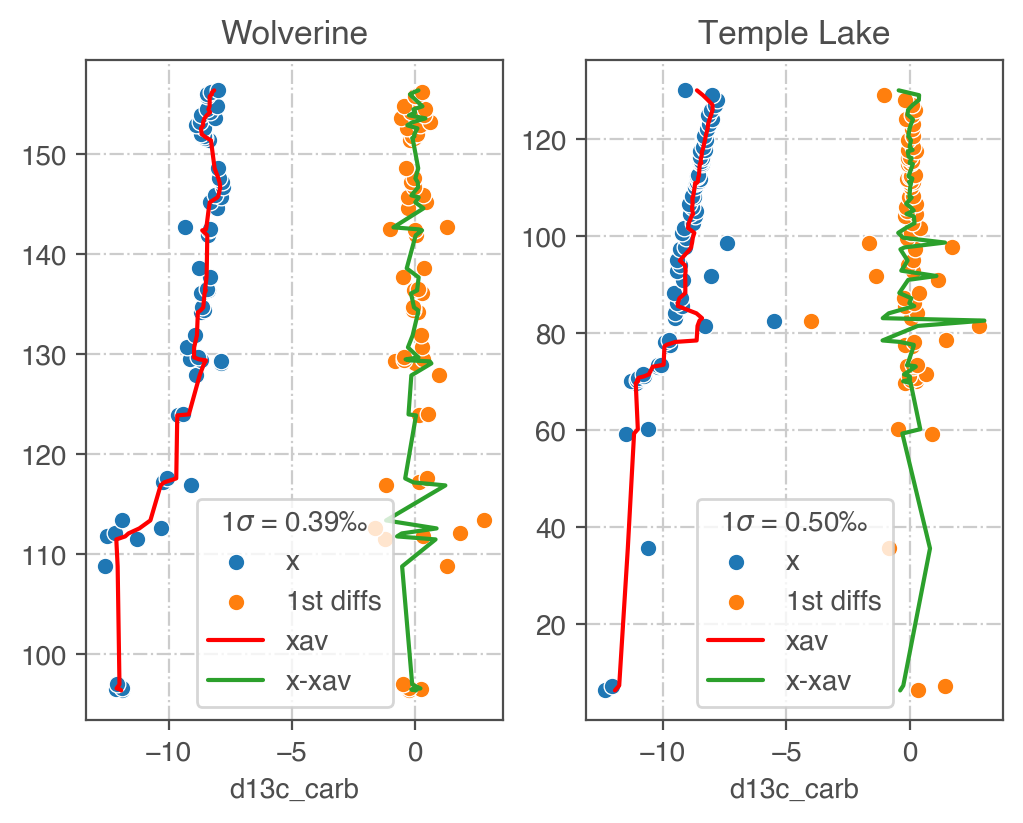

In [59]:
fig,ax = plt.subplots(1,len(ll),figsize=(5,4),layout='constrained')
axs = ax.ravel()
avs_l = []
for i,loc in zip(axs,set(dfl['index'])):
    sub = dfl[dfl['index']==loc]
    x = sub['d13c_carb']
    y = sub['sample_height']
    fd = np.diff(x) # first difference
    sns.scatterplot(x=x,y=y,ax=i,label='x')
    sns.scatterplot(x=fd,y=y[:-1],ax=i,label='1st diffs')
    window_size = 5
    x_av = moving_average(x,window_size)
    i.plot(x_av,y,'-',c='r',label='xav')
    i.set_title(loc)
    i.grid()
    i.set_ylabel(None)
    x_diff = x-x_av # order doesn't matter here
    i.plot(x_diff,y,'-',c='C2',label='x-xav')
    x_diff_std = np.std(x_diff)
    i.legend(title=f'1$\sigma$ = {x_diff_std:.2f}‰')
    avs_l.append(x_diff_std)
avs_l = np.array(avs_l)
print(f'mean std lake louise = {np.mean(avs_l):.3f}‰')

### Jasper

#### Need to split up all the GSM Type data

In [50]:
# separating GSM Type
gt = dfj[dfj['index']=='GSM Type'] # all gsm type
gt1 = gt[~gt['sample_name'].str.contains('C2')] # all that are not C2 samples
gt2 = gt[gt['sample_name'].str.contains('C2')] # all c2 samples

# splitting up the non c2 samples
gt3 = gt1[gt1['sample_height']<50].reset_index(drop=True) # lowest dat
gt3['index'] = 'gt3'
gt4 = gt1[(gt1['sample_height']>180)&(gt1['sample_height']<300)].reset_index(drop=True) # highest data
gt4['index'] = 'gt4'
gt5 = gt1[(gt1['sample_height']>100)&(gt1['sample_height']<180)].reset_index(drop=True) # middle data
gt5['index'] = 'gt5'

# rebuild jasper df
dfj1 = pd.concat([gt2,gt3,gt4,gt5]).reset_index(drop=True)
dfj2 = dfj[dfj['index']!='GSM Type'].reset_index(drop=True)
dfJ = pd.concat([dfj2,dfj1])

mean std jasper = 0.177‰


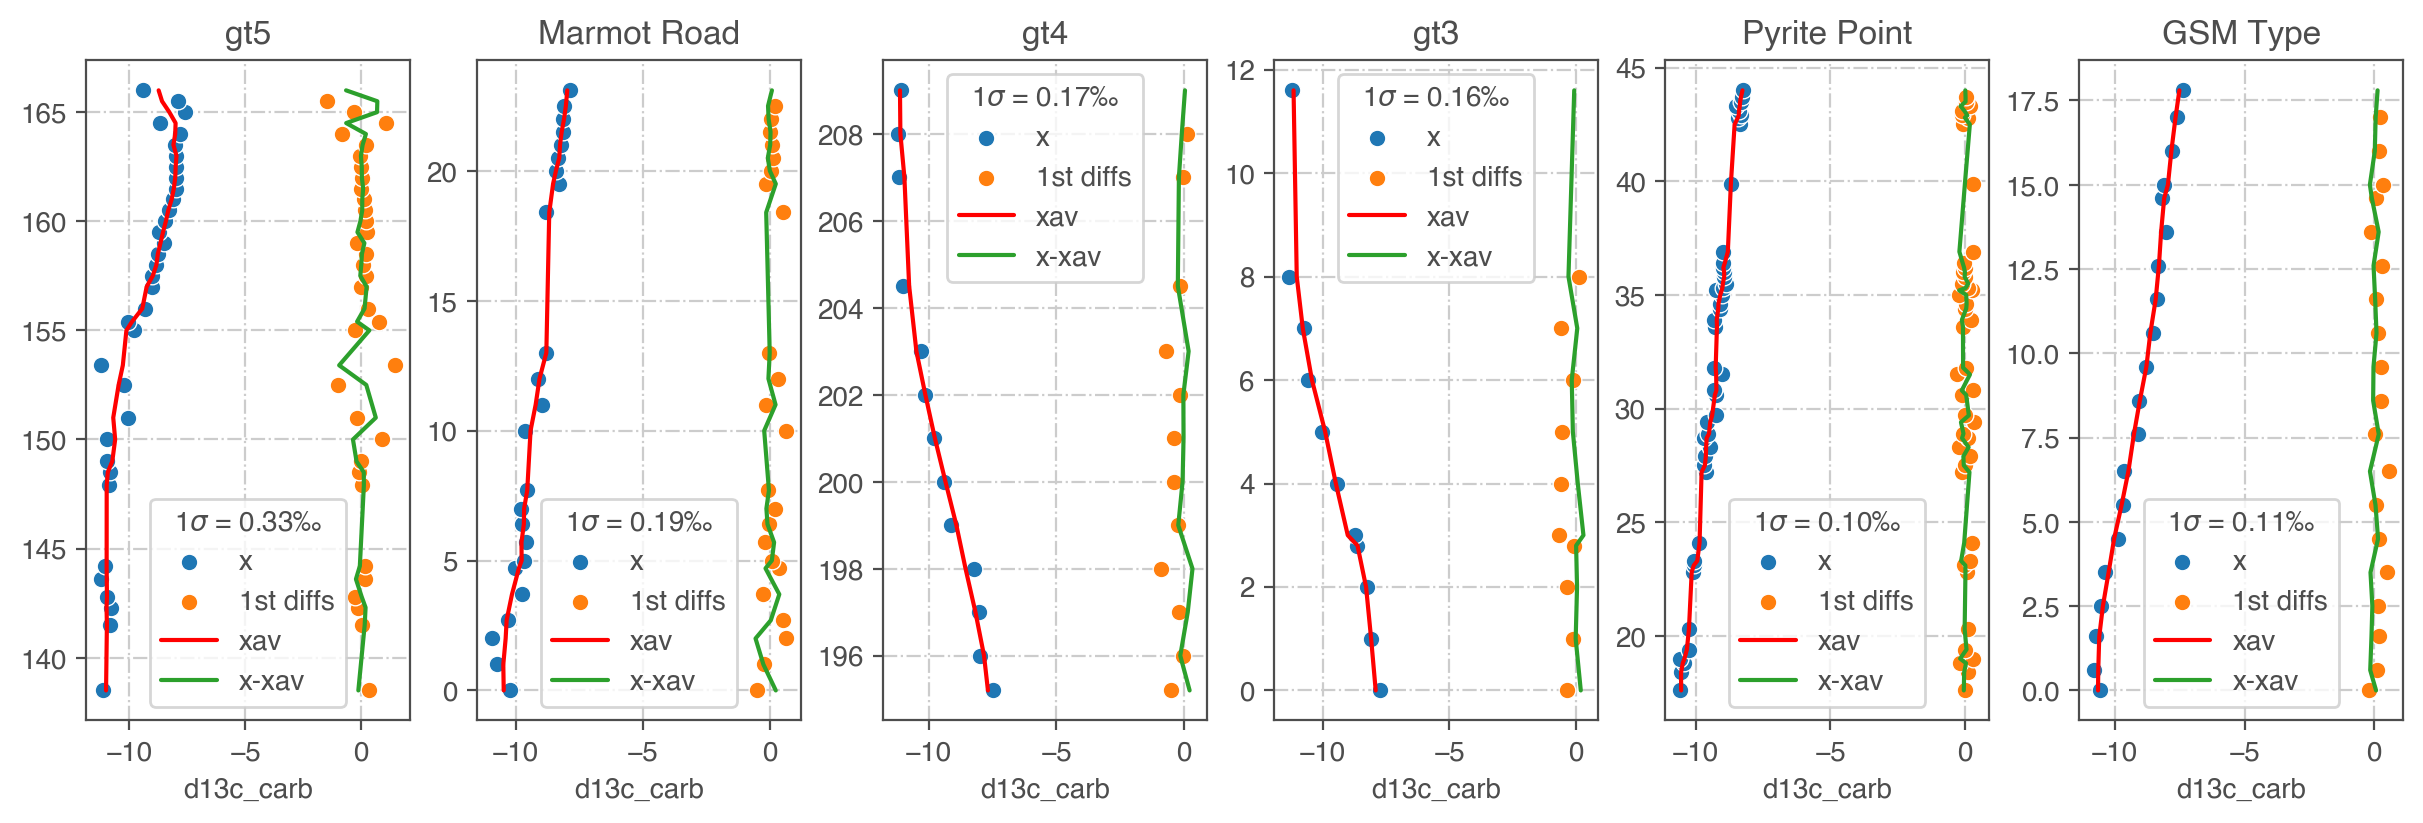

In [58]:
fig,ax = plt.subplots(1,len(set(dfJ['index'])),figsize=(12,4),layout='constrained')
axs = ax.ravel()
avs_j = []

for i,loc in zip(axs,set(dfJ['index'])):
    sub = dfJ[dfJ['index']==loc]
    x = sub['d13c_carb']
    y = sub['sample_height']
    fd = np.diff(x) # first difference
    sns.scatterplot(x=x,y=y,ax=i,label='x')
    sns.scatterplot(x=fd,y=y[:-1],ax=i,label='1st diffs')
    window_size = 5
    x_av = moving_average(x,window_size)
    i.plot(x_av,y,'-',c='r',label='xav')
    i.set_title(loc)
    i.grid()
    i.set_ylabel(None)
    x_diff = x-x_av # order doesn't matter here
    i.plot(x_diff,y,'-',c='C2',label='x-xav')
    x_diff_std = np.std(x_diff)
    i.legend(title=f'1$\sigma$ = {x_diff_std:.2f}‰')
    avs_j.append(x_diff_std)
avs_j = np.array(avs_j)
print(f'mean std jasper = {np.mean(avs_j):.3f}‰')


### Both Averages

In [55]:
print(f'mean std lake louise = {np.mean(avs_l):.2f}‰')
print(f'mean std jasper = {np.mean(avs_j):.2f}‰')

mean std lake louise = 0.44‰
mean std jasper = 0.18‰


### McKale for fun (WMM)

std mckale = 0.555‰


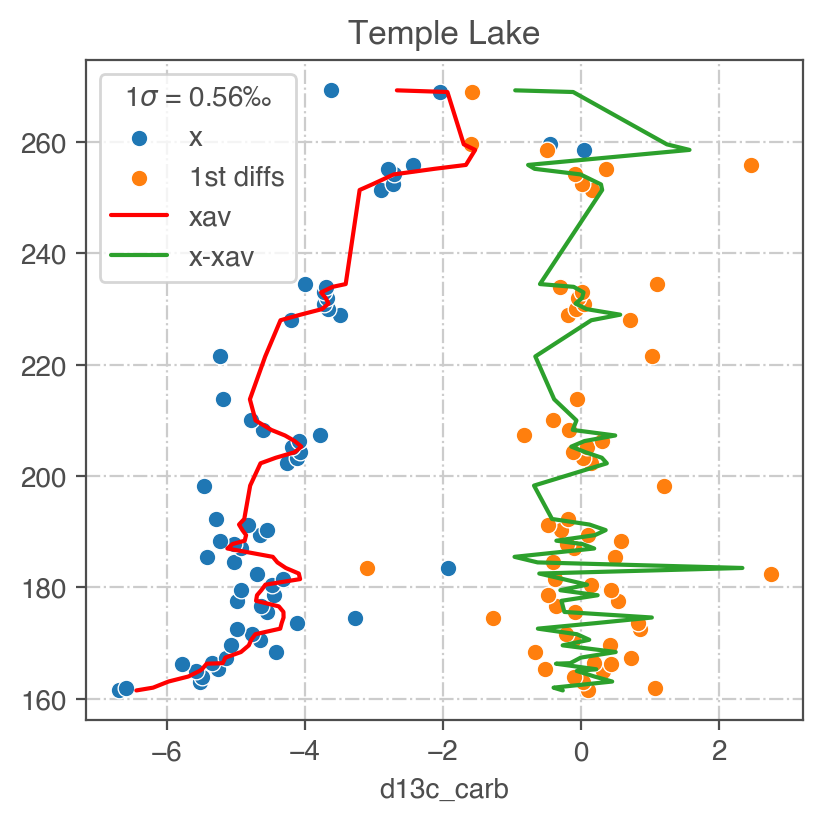

In [86]:
fig,ax = plt.subplots(1,1,figsize=(4,4),layout='constrained')

avs_m = []
sub = wmm[wmm['index']=='McKale Creek']
x = sub['d13c_carb']
y = sub['sample_height']
fd = np.diff(x) # first difference
sns.scatterplot(x=x,y=y,ax=ax,label='x')
sns.scatterplot(x=fd,y=y[:-1],ax=ax,label='1st diffs')
window_size = 5
x_av = moving_average(x,window_size)
ax.plot(x_av,y,'-',c='r',label='xav')
ax.set_title(loc)
ax.grid()
ax.set_ylabel(None)
x_diff = x-x_av # order doesn't matter here
ax.plot(x_diff,y,'-',c='C2',label='x-xav')
x_diff_std = np.std(x_diff)
ax.legend(title=f'1$\sigma$ = {x_diff_std:.2f}‰')
avs_m.append(x_diff_std)
avs_m = np.array(avs_m)
print(f'std mckale = {avs_m[0]:.3f}‰')


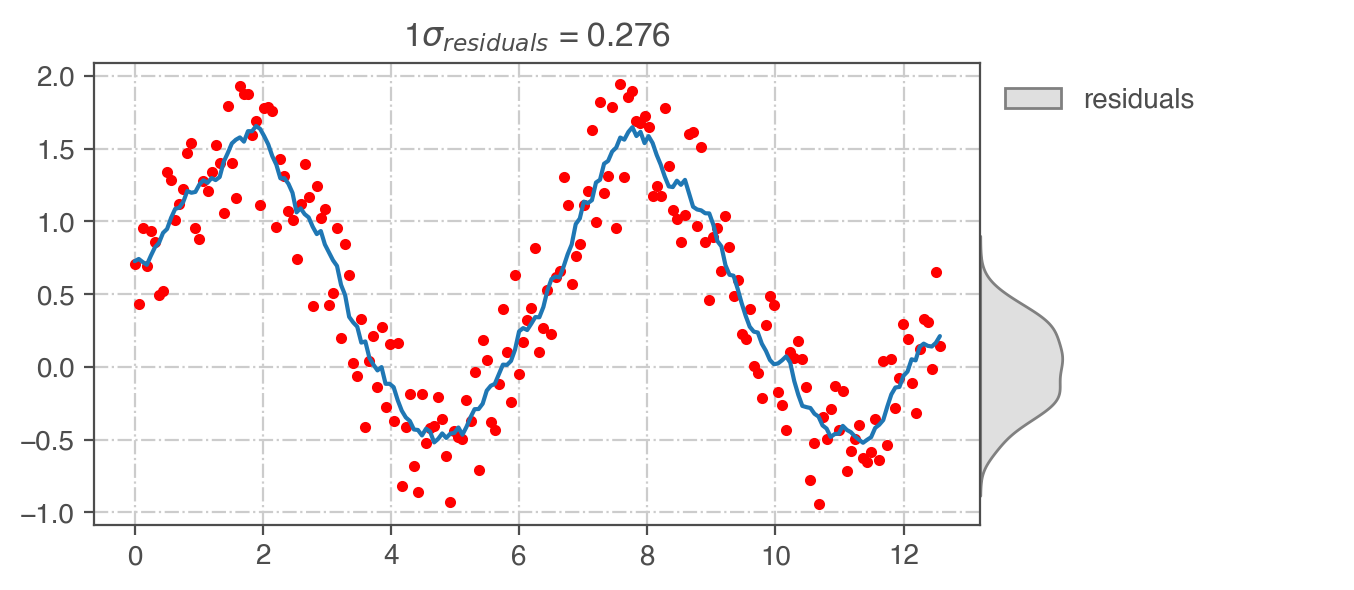

In [271]:
fig,ax = plt.subplots(1,2,figsize=(8,3),width_ratios=[1,0.4],sharey=True)
plt.subplots_adjust(wspace=0)
x = np.linspace(0,4*np.pi,200)
y = np.sin(x) + np.random.uniform(size=x.shape)
ax[0].plot(x,y,'.r')
ya = moving_average(y,10)
ax[0].plot(x,ya,'-')
ax[0].grid()
diff = y-ya
#ax[0].plot(x,diff,color='grey',zorder=1,alpha=0.4)
ax[0].set_title(f'1$\sigma_{{residuals}}$ = {np.std(diff):.3f}')
sns.kdeplot(y=diff,ax=ax[1],fill=True,color='grey',label='residuals')
ax[1].set_xlim(right=5)
ax[1].axis('off')
ax[1].legend(loc=2,frameon=False)
ax[0].set_zorder(100)